<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Подключаем все необходимые для выполнения проекта библиотеки:

In [155]:
import pandas as pd # обработка и анализ табличных данных

from sklearn.model_selection import train_test_split # выделение обучающей и тестовой выборок
from sklearn.model_selection import cross_val_score # кросс-валидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров для лучшей модели
from sklearn.model_selection import TimeSeriesSplit # кросс-валидация в случае временного ряда

from sklearn.metrics import mean_squared_error # метрика MSE

from sklearn.linear_model import LinearRegression # модель линейной регрессии
from sklearn.ensemble import RandomForestRegressor # модель случайного леса

from statsmodels.tsa.seasonal import seasonal_decompose # разложение временного ряда на составляющие

import matplotlib.pyplot as plt # построение графиков

from sklearn.dummy import DummyRegressor # случайная модель

Загружаем данные из текстового файла:

In [156]:
data = pd.read_csv('/datasets/taxi.csv')

Выводим общую информацию о данных:

In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Изучаем данные:

In [158]:
data.sample(5)

,datetime,num_orders
6208,2018-04-13 02:40:00,5
20993,2018-07-24 18:50:00,29
14395,2018-06-08 23:10:00,12
10615,2018-05-13 17:10:00,24
3247,2018-03-23 13:10:00,8


Изменим тип данных Datetime с object на datetime64:

In [159]:
data['datetime'] = pd.to_datetime(data['datetime'])

Установим индекс таблицы равным столбцу datetime

In [160]:
data.set_index('datetime', inplace=True)

Сортируем индексы в хронологическом порядке:

In [161]:
data.sort_index(inplace=True)

Проверяем, что получилось:

In [162]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Построим график временного ряда за весь период наблюдения:

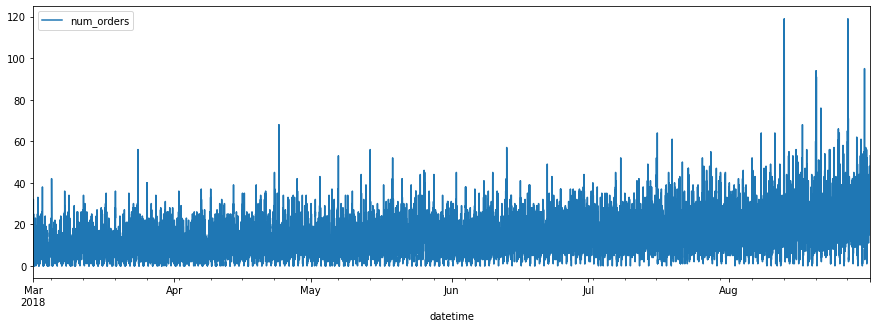

In [163]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
data.plot();

За один месяц (март):

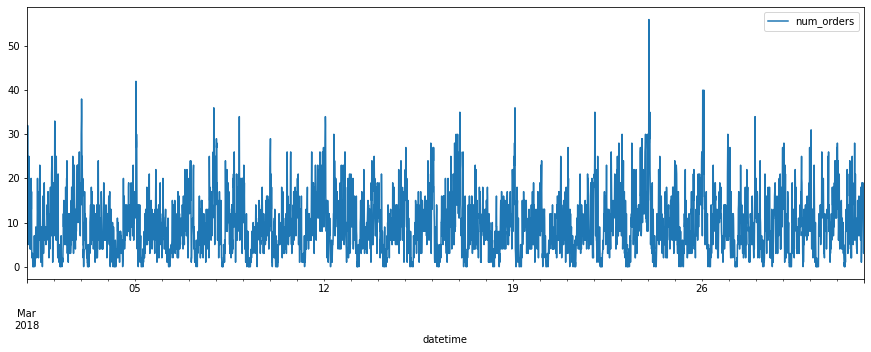

In [164]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
data['2018-03-01':'2018-03-31'].plot();

За одну неделю (с понедельника по воскресенье, с 5 по 11 марта):

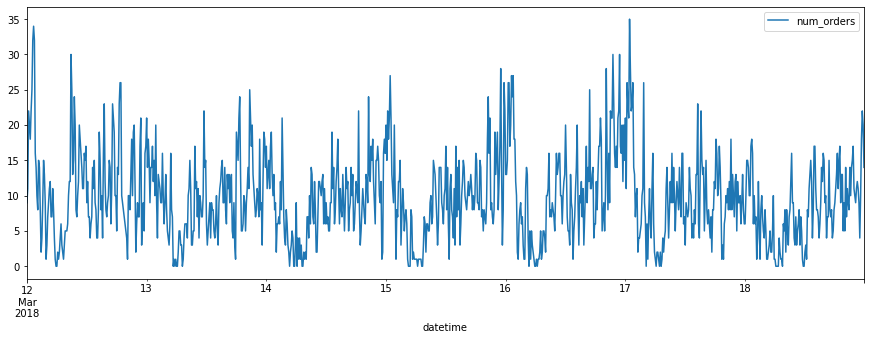

In [165]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
data['2018-03-12':'2018-03-18'].plot();

За один день (1 марта):

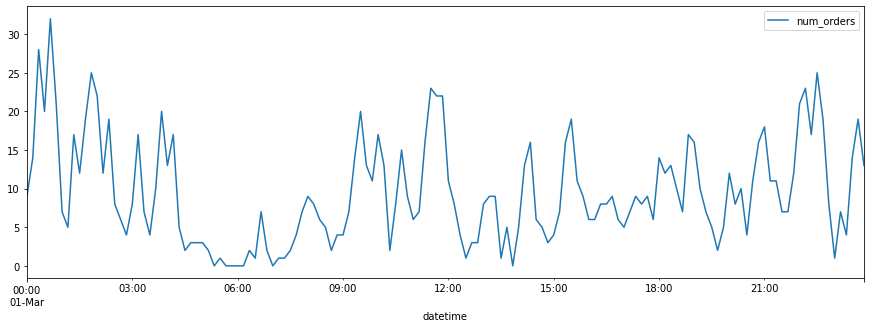

In [166]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
data['2018-03-01':'2018-03-01'].plot();

Сдлеаем ресемплирование данных по 1 часу:

In [167]:
data = data.resample('1H').sum()

## Анализ

Разложим временной ряд на тренд и сезонную компоненту

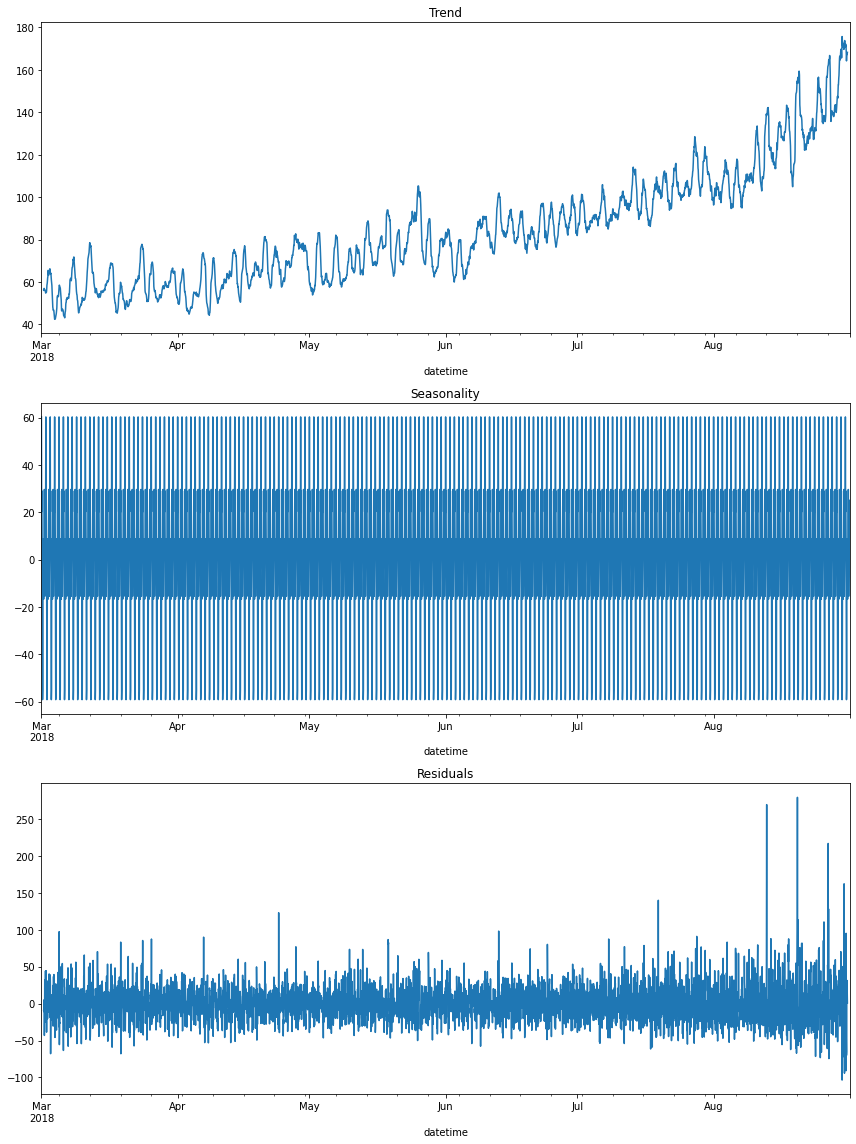

In [168]:
decomposed = seasonal_decompose(data) # < напишите код здесь >

plt.figure(figsize=(12, 16))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

Построим график сезонной составляющей за первые 3 дня марта:

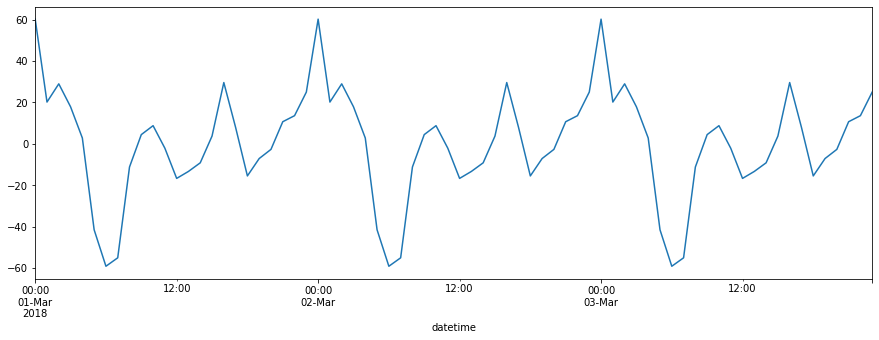

In [169]:
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(); 

Чтобы увидеть недельную сезонность, сделаем ресемплирование по суткам и построим график сезонной компоненты за один месяц (например, за апрель, так как там не было праздничных дней):

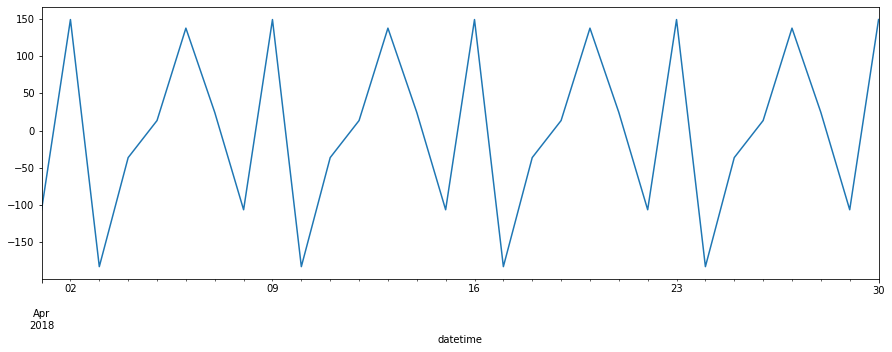

In [170]:
week_resmple_data = data.resample('1D').sum()

week_resmple_decomposed = seasonal_decompose(week_resmple_data)

week_resmple_decomposed.seasonal['2018-04-01':'2018-04-30'].plot(); 

Изучим временной ряд на стационарность - рассчитаем скользящее среднее и стандартное отклонение:

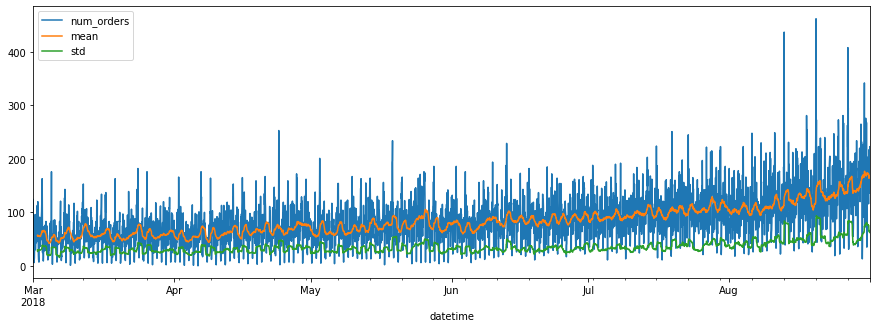

In [171]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot();
data = data.drop(['mean', 'std'], axis=1)

**Выводы**

Ряд нестационарный, так как среднее и стандартное отклонение измненяются во времени. Наблюдается тренд (плавное изменение среднего значения ряда без повторяющихся закономерностей) - увеличение числа заказов в течение года. Наблюдается совершенно чёткая сезонность (циклично повторяющиеся закономерности во временном ряду) внутри суток - максимум заказов в районе 12 часов ночи, минимум - в районе 6 утра. Также наблюдается недельная сезонность - максимум заказов в понедельник и в пятницу, минимум - во вторник и в субботу.

## Обучение

Напишем функцию для создания признаков:
- календарные - день, день недели и час заказа;
- отстающие значения;
- скользящее среднее.

In [172]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Подберём оптимальные значения параметров максимального числа лагов и размера скользящего окна:

In [130]:
%%time

best_model = None
best_result = 1000000
for max_lag in (2, 4, 6, 12, 24, 48, 72, 96, 120):
    for rolling_mean_size in (2, 4, 6, 12, 24, 48, 72, 120):
        make_features(data, max_lag, rolling_mean_size)
        data_1 = data.copy()
        train, test = train_test_split(data_1, shuffle=False, test_size=0.1)
        train = train.dropna()
        feature_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        feature_test = test.drop('num_orders', axis=1)
        target_test = test['num_orders']
        
        model = LinearRegression()
        model.fit(feature_train, target_train)
        result = mean_squared_error(target_train, model.predict(feature_train))**0.5
        
        if result < best_result:
            best_model = model
            best_result = result
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            
        del data_1  # удаляем копию после каждого прохода

print("RMSE лучшей модели случайного леса:", best_result, "Количество отстающих значений (лагов):", best_max_lag, 
      "Размер скользящего окна:", best_rolling_mean_size)

RMSE лучшей модели случайного леса: 21.79102249999908 Количество отстающих значений (лагов): 120 Размер скользящего окна: 2
CPU times: user 6.22 s, sys: 10.6 s, total: 16.8 s
Wall time: 16.7 s


Создадим признаки с оптимальными значениями параметров:

In [173]:
make_features(data, 120, 2)

Выделяем обучающую и тестовые выборки:

In [174]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

Отдельно выделяем признаки и целевой признак:

In [175]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Строим модель линейной регресии:

In [176]:
model_lr = LinearRegression()

model_lr.fit(features_train, target_train)

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model_lr, features_train, 
                         target_train, cv=tscv, scoring='neg_root_mean_squared_error') 
final_score = scores.mean()

print("Значение метрики RMSE для модели линейной регрессии на обучающей выборке", -final_score)

Значение метрики RMSE для модели линейной регрессии на обучающей выборке 23.62591469491968


Строим модель случайного леса:

In [177]:
n_estimators = range(10, 51, 10)
max_depth = range(1, 11)
hyperparameters_rf = dict(n_estimators=n_estimators, max_depth=max_depth)

model_rf = RandomForestRegressor(random_state=12345)
gridsearch_rf = GridSearchCV(model_rf, hyperparameters_rf, cv=tscv, scoring='neg_root_mean_squared_error')
best_model_rf = gridsearch_rf.fit(features_train, target_train)
print(best_model_rf.best_params_)
print("Значение метрики RMSE лучшей модели случайного леса", -best_model_rf.best_score_)

{'max_depth': 10, 'n_estimators': 50}
Значение метрики RMSE лучшей модели случайного леса 23.950744099908963


**Выводы** 

На обучающей выборке наилучший результат показала модель линейной регрессии - RMSE модели 23.63 заказов. Практически такие же результаты у модели случайного леса с числом деревьев 50 и максимальной глубиной 10 - RMSE 23.95. Так как класс линейных моделей лучше подходят для пронозирования врменных рядов, в качестве итоговой модели выберем именно модель линейной регрессии.

## Тестирование

In [154]:
best_model = LinearRegression()

best_model.fit(features_train, target_train)
predictions_test = best_model.predict(features_test)

rmse_bm = mean_squared_error(target_test, predictions_test)**0.5

print('RMSE наилучшей модели линейной регрессии на тестовой выборке', rmse_bm)

RMSE наилучшей модели случайного леса на тестовой выборке 39.28715336404608


Сравниваем с константной моделью:

In [105]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predictions_test = dummy_regr.predict(features_test)

rmse_dr = mean_squared_error(target_test, predictions_test)**0.5

print('RMSE константной модели', rmse_dr)

RMSE константной модели 84.33215679398195


**Выводы**

Значение RMSE константной модели 84.3 заказа, итоговой случайного леса - 40.3. Модель проходит проверку на адекватность. Однако точность модели невысокая, так как среднее значение количества заказов в исследуемом наборе данных составляет 84.4.